In [1]:
pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 14.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=14daebf437bcb52ba59de4c21f4885f3a08fe3dab72588d9e4e091dd67cc2781
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'customers.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
customers = pd.read_csv(file_content_stream)
customers.head()

,ID,Visit_Time,Average_Expense,Sex,Age
0,1,3,5.7,0,10
1,2,5,14.5,0,27
2,3,16,33.5,0,32
3,4,5,15.9,0,30
4,5,16,24.9,0,23


In [3]:
customers = customers.drop(columns = 'ID', axis = 1)
scaler = MinMaxScaler()
customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']] = scaler.fit_transform(customers)
customers.head()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1
0,3,5.7,0,10,0.117647,0.041096,0.0,0.051282
1,5,14.5,0,27,0.235294,0.342466,0.0,0.487179
2,16,33.5,0,32,0.882353,0.993151,0.0,0.615385
3,5,15.9,0,30,0.235294,0.390411,0.0,0.564103
4,16,24.9,0,23,0.882353,0.698630,0.0,0.384615


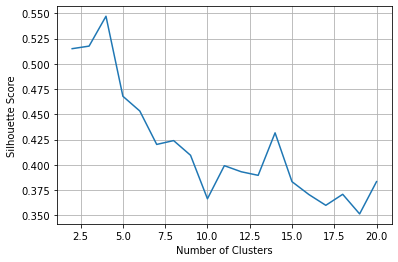

In [6]:
silo_score = list()

for i in range(2, 21):
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']])
    silo_score.append(silhouette_score(customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']], kmeans_md.labels_))

import matplotlib.pyplot as plt
plt.plot(range(2, 21), silo_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [7]:
X = customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']]

# Fuzzy C-means with 4 clusters
fc, W, u0, d, jm, p, pc = cmeans(X.T, c = 4, m = 1.25, error = 1e-6, maxiter = 1000)

In [8]:
customers['cluster'] = np.nan

customers['cluster'] = np.where(W[0] > .7, 1, customers['cluster'])
customers['cluster'] = np.where(W[1] > .7, 2, customers['cluster'])
customers['cluster'] = np.where(W[2] > .7, 3, customers['cluster'])
customers['cluster'] = np.where(W[3] > .7, 4, customers['cluster'])

In [9]:
cluster_1 = customers[customers['cluster'] ==1].reset_index(drop = True)
cluster_1.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.0,24.000000,24.0
mean,5.416667,10.591667,1.0,15.291667,0.259804,0.208619,1.0,0.186966,1.0
std,2.430185,4.474752,0.0,4.666990,0.142952,0.153245,0.0,0.119666,0.0
min,1.000000,4.500000,1.0,8.000000,0.000000,0.000000,1.0,0.000000,1.0
25%,3.000000,7.875000,1.0,11.750000,0.117647,0.115582,1.0,0.096154,1.0
50%,6.000000,10.900000,1.0,16.000000,0.294118,0.219178,1.0,0.205128,1.0
75%,7.000000,12.000000,1.0,17.500000,0.352941,0.256849,1.0,0.243590,1.0
max,10.000000,23.800000,1.0,23.000000,0.529412,0.660959,1.0,0.384615,1.0


In [10]:
cluster_2 = customers[customers['cluster'] == 2].reset_index(drop = True)
cluster_2.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.0,16.000000,16.0
mean,12.250000,25.362500,1.0,31.187500,0.661765,0.714469,1.0,0.594551,2.0
std,2.955221,4.336339,0.0,8.336416,0.173837,0.148505,0.0,0.213754,0.0
min,8.000000,17.800000,1.0,17.000000,0.411765,0.455479,1.0,0.230769,2.0
25%,10.000000,21.100000,1.0,26.000000,0.529412,0.568493,1.0,0.461538,2.0
50%,12.000000,25.450000,1.0,28.500000,0.647059,0.717466,1.0,0.525641,2.0
75%,13.250000,28.275000,1.0,36.750000,0.720588,0.814212,1.0,0.737179,2.0
max,18.000000,33.700000,1.0,47.000000,1.000000,1.000000,1.0,1.000000,2.0


In [11]:
cluster_3 = customers[customers['cluster'] == 3].reset_index(drop = True)
cluster_3.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.0,8.000000,8.0
mean,14.375000,25.587500,0.0,26.625000,0.786765,0.722175,0.0,0.477564,3.0
std,1.846812,4.647714,0.0,5.629958,0.108636,0.159168,0.0,0.144358,0.0
min,12.000000,18.800000,0.0,18.000000,0.647059,0.489726,0.0,0.256410,3.0
25%,13.500000,22.950000,0.0,22.750000,0.735294,0.631849,0.0,0.378205,3.0
50%,14.000000,25.400000,0.0,26.000000,0.764706,0.715753,0.0,0.461538,3.0
75%,16.000000,28.500000,0.0,32.250000,0.882353,0.821918,0.0,0.621795,3.0
max,17.000000,33.500000,0.0,33.000000,0.941176,0.993151,0.0,0.641026,3.0


In [12]:
cluster_4 = customers[customers['cluster'] == 4].reset_index(drop = True)
cluster_4.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,11.000000,11.000000,11.0,11.00000,11.000000,11.000000,11.0,11.000000,11.0
mean,4.909091,12.709091,0.0,17.00000,0.229947,0.281133,0.0,0.230769,4.0
std,1.700267,6.060108,0.0,6.78233,0.100016,0.207538,0.0,0.173906,0.0
min,3.000000,4.600000,0.0,9.00000,0.117647,0.003425,0.0,0.025641,4.0
25%,3.500000,7.150000,0.0,12.00000,0.147059,0.090753,0.0,0.102564,4.0
50%,5.000000,14.500000,0.0,16.00000,0.235294,0.342466,0.0,0.205128,4.0
75%,6.000000,16.000000,0.0,20.00000,0.294118,0.393836,0.0,0.307692,4.0
max,8.000000,23.800000,0.0,30.00000,0.411765,0.660959,0.0,0.564103,4.0
